In [1]:
import os
import numpy as np
import pandas as pd

import h5py

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# read test file

# test_fn = '/zfssz2/ST_MCHRI/BIGDATA/PROJECT/NIPT_CNV/f_cnv_out/online/1KGP/win_10000/ns10_nr5.h5'
test_fn = '/zfssz2/ST_MCHRI/BIGDATA/PROJECT/NIPT_CNV/f_cnv_out/online/1KGP/win_10000/ns29_nr5.h5'
#test_fn_dir = '/zfssz2/ST_MCHRI/BIGDATA/PROJECT/NIPT_CNV/f_cnv_out/online/1KGP_bak/'
# with h5py.File(os.path.join(test_fn_dir, 'ns10_nr11.h5'),'r') as h5_fn:
with h5py.File(test_fn,'r') as h5_fn:
    all_tp_fp_fn = h5_fn.get('all_tp_fp_fn').value
    del_tp_fp_fn = h5_fn.get('del_tp_fp_fn').value
    dup_tp_fp_fn = h5_fn.get('dup_tp_fp_fn').value


In [27]:
all_tp_fp_fn_2d = all_tp_fp_fn.reshape(
    (all_tp_fp_fn.shape[0]*all_tp_fp_fn.shape[1], all_tp_fp_fn.shape[2]))

# all_tp_fp_fn_2d = del_tp_fp_fn.reshape(
#     (del_tp_fp_fn.shape[0]*del_tp_fp_fn.shape[1], del_tp_fp_fn.shape[2]))

# all_tp_fp_fn_2d = dup_tp_fp_fn.reshape(
#     (dup_tp_fp_fn.shape[0]*dup_tp_fp_fn.shape[1], dup_tp_fp_fn.shape[2]))

tmp_all_tp_fp_fn_df = pd.DataFrame(data=all_tp_fp_fn_2d, 
                                       columns=['RANGE_LOW','TP','FP', 'TP_FN'])
# tmp_all_tp_fp_fn_df = tmp_all_tp_fp_fn_df[tmp_all_tp_fp_fn_df['RANGE_LOW']<=6000]
tmp_all_tp_fp_fn_df['FN'] = tmp_all_tp_fp_fn_df['TP_FN'] - tmp_all_tp_fp_fn_df['TP']
tmp_all_tp_fp_fn_df['RECALL'] = tmp_all_tp_fp_fn_df['TP']/(tmp_all_tp_fp_fn_df['TP_FN'])
tmp_all_tp_fp_fn_df['PRECISION'] = tmp_all_tp_fp_fn_df['TP']/(tmp_all_tp_fp_fn_df['TP']+tmp_all_tp_fp_fn_df['FP'])

tmp_all_tp_fp_fn_df.head()

,RANGE_LOW,TP,FP,TP_FN,FN,RECALL,PRECISION
0,2000,160,1670,927,767,0.172600,0.087432
1,10000,100,480,747,647,0.133869,0.172414
2,20000,65,180,519,454,0.125241,0.265306
3,50000,33,38,202,169,0.163366,0.464789
4,100000,7,3,68,61,0.102941,0.700000


In [28]:
gp_all_df = tmp_all_tp_fp_fn_df.groupby('RANGE_LOW').agg({'TP': ['median', 'std'], 
                                                          'FP': ['median', 'std'],
                                                          'FN': ['median', 'std']})
new_cols = ['_'.join(t) for t in gp_all_df.columns]
gp_all_df.columns = new_cols

gp_all_df

,TP_median,TP_std,FP_median,FP_std,FN_median,FN_std
RANGE_LOW,,,,,,
2000,120,28.693728,1809,382.265962,597,182.445390
10000,70,19.545513,480,105.921630,465,168.662085
20000,41,13.297468,151,46.315129,288,135.872994
50000,16,8.565166,19,12.639663,83,68.139418
100000,6,4.304597,3,2.858743,20,28.833734


In [29]:
(gp_all_df.groupby(gp_all_df.columns.str[0:2], axis=1)
              .apply(lambda x: x.astype(str).apply('±'.join, 1)))

,FN,FP,TP
RANGE_LOW,,,
2000,597±182.4453896294569,1809±382.2659624003322,120±28.69372839595934
10000,465±168.6620852912068,480±105.9216296401059,70±19.545513387886725
20000,288±135.87299379696375,151±46.31512855433875,41±13.29746818377552
50000,83±68.13941807475685,19±12.639663118289285,16±8.56516602089634
100000,20±28.83373434803758,3±2.8587433940638056,6±4.304597153073246


In [30]:
# all_tp_fp_fn_df = pd.melt(tmp_all_tp_fp_fn_df, 
#                           id_vars=['RANGE_LOW'], value_vars=['TP','FP', 'FN'],
#                          var_name='PRED_TYPE', value_name='COUNT')

all_tp_fp_fn_df = pd.melt(tmp_all_tp_fp_fn_df, 
                          id_vars=['RANGE_LOW'], value_vars=['RECALL','PRECISION'],
                         var_name='PRED_MET', value_name='RATIO')

In [31]:
all_precision=all_tp_fp_fn_df[all_tp_fp_fn_df['PRED_MET']=='PRECISION']

Text(0.5,0,'Predicted CNV size(bp)')

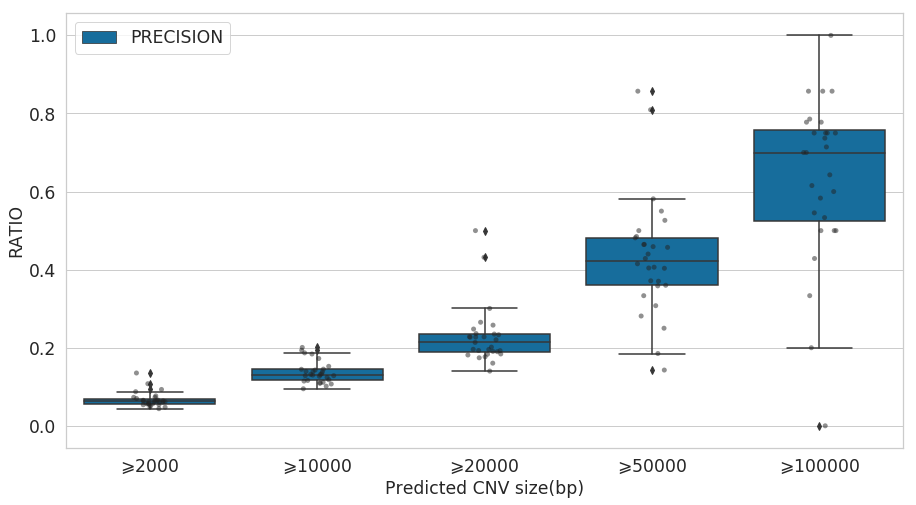

In [32]:
# reg_size = [0,1000,2000,3000, 4000, 5000,6000]
reg_size = [2000,10000, 20000, 50000, 100000]
sns.set(style="whitegrid")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
bp = sns.boxplot(y='RATIO', x='RANGE_LOW', 
                     data=all_precision, 
                     palette="colorblind", 
                     hue='PRED_MET')
    
    # make grouped stripplot and save it in a variable
bp = sns.stripplot(y='RATIO', x='RANGE_LOW', 
                       data=all_precision, 
                       jitter=True,
                       dodge=True, 
                       marker='o', 
                       alpha=0.5,
                       hue='PRED_MET',
                       color='grey')
    # get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()
    # specify just one legend
    # l = plt.legend(handles[0:1], labels[0:1])
l = plt.legend(handles[0:1], labels[0:1])

x_tlabel_lst = []
for reg_s in reg_size:
    str_l = r"$\geqslant"+str(reg_s)+"$"
    x_tlabel_lst.append(str_l)
    
bp.set_xticklabels(x_tlabel_lst)
plt.xlabel('Predicted CNV size(bp)')

Text(0.5,0,'Predicted CNVs size(bp)')

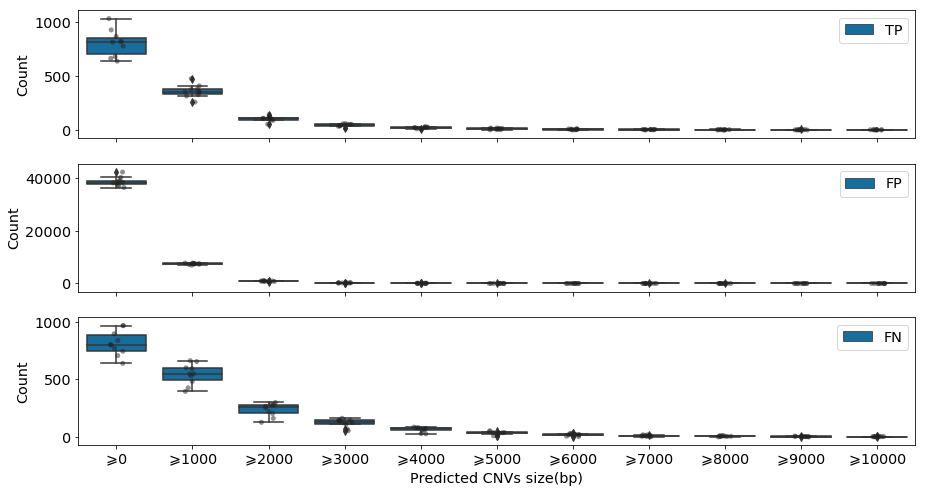

In [100]:
reg_size = [2000,10000, 20000, 50000, 100000]
# reg_size = [0,1000,2000,3000, 4000, 5000]
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

pred_re_types = ['TP', 'FP', 'FN']
f, axs = plt.subplots(len(pred_re_types),1, sharex=True, )

for i, i_type in enumerate(pred_re_types):
    bp = sns.boxplot(y='COUNT', x='RANGE_LOW', 
                     data=all_tp_fp_fn_df[all_tp_fp_fn_df['PRED_TYPE']==i_type], 
                     palette="colorblind", 
                     hue='PRED_TYPE',
                     ax=axs[i])
    
    # make grouped stripplot and save it in a variable
    bp = sns.stripplot(y='COUNT', x='RANGE_LOW', 
                       data=all_tp_fp_fn_df[all_tp_fp_fn_df['PRED_TYPE']==i_type], 
                       jitter=True,
                       dodge=True, 
                       marker='o', 
                       alpha=0.5,
                       hue='PRED_TYPE',
                       color='grey',
                       ax=axs[i])
    # get legend information from the plot object
    handles, labels = bp.get_legend_handles_labels()
    # specify just one legend
    # l = plt.legend(handles[0:1], labels[0:1])
    l = axs[i].legend(handles[0:1], labels[0:1])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('')

x_tlabel_lst = []
for reg_s in reg_size:
    str_l = r"$\geqslant"+str(reg_s)+"$"
    x_tlabel_lst.append(str_l)
    
bp.set_xticklabels(x_tlabel_lst)
plt.xlabel('Predicted CNVs size(bp)')


In [33]:
all_tp_fp_fn_2d

array([[    0,  1035, 37637,  1931],
       [ 1000,   478,  7367,  1079],
       [ 2000,   143,   880,   424],
       [ 3000,    52,   211,   200],
       [ 4000,    26,    70,   112],
       [ 5000,    16,    25,    56],
       [ 6000,     6,     8,    30],
       [ 7000,     3,     4,    15],
       [ 8000,     3,     2,    11],
       [ 9000,     2,     1,     8],
       [10000,     2,     0,     5],
       [    0,   639, 40344,  1278],
       [ 1000,   259,  6965,   655],
       [ 2000,    53,   615,   181],
       [ 3000,    15,   109,    70],
       [ 4000,     5,    20,    35],
       [ 5000,     1,     5,    12],
       [ 6000,     1,     1,     9],
       [ 7000,     1,     0,     6],
       [ 8000,     1,     0,     5],
       [ 9000,     0,     0,     3],
       [10000,     0,     0,     3],
       [    0,   780, 38307,  1747],
       [ 1000,   376,  7581,  1031],
       [ 2000,   115,   916,   398],
       [ 3000,    52,   216,   193],
       [ 4000,    22,    77,    97],
 

In [10]:
# load the test results using the model trained by 1:1:1 training dataset
test_res_dir = os.path.join(test_result_root_dir, 'model111/test_out')
test_res_fname = os.path.join(test_res_dir, test_res_fn+'-offline-test.h5')

In [11]:
with h5py.File(test_res_fname, 'r') as test_out:
    ypred = test_out.get('ypred').value
    ytrue = test_out.get('ytrue').value

In [12]:
ytrue[848663]

1

In [13]:
ypred[848663]

array([1.8141792e-10, 1.0000000e+00, 1.8170587e-12], dtype=float32)

In [14]:
in_put = np.load('/zfssz2/ST_MCHRI/BIGDATA/PROJECT/NIPT_CNV/f_cnv_out/data/w1000_r0.10_f0.01/dataset/NA12878_DEL_2.npz')

x = in_put['x']

# 1|7510013|7511460|1447|DEL|0.161741|1

In [24]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.25      , 0.84210526, 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.25      , 0.89473684, 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.75      , 0.92105263, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.75      , 0.85087711, 1.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.84210526, 1.        , ..., 0.        , 1.        ,
        0.        ]])

In [38]:
# f_online_feat = '/zfssz2/ST_MCHRI/BIGDATA/PROJECT/NIPT_CNV/f_cnv_out/online/NA12878/data/NA12878_chr1_features_whole.h5'
f_online_feat='/zfssz6/ST_MCHRI/BIGDATA/P18Z10200N0124/NIPT_CNV/NIPT_CNV/online_calling_features/252_0.1X_NIPT_like_1000genome_testsample_online_calling_features/NA12878/data/NA12878_chr1_features_whole.h5'

with h5py.File(f_online_feat, 'r') as f_online:
    feat = f_online.get('feature').value
    pos = f_online.get('base_cov_pos_idx').value

In [21]:
feat.shape

(248956422, 13)

In [48]:
pos[7511460-1000:7511460]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [56]:
feat[7510455:7511455]
#7510013

array([[ 0.      ,  0.      ,  0.      , ...,  1.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  1.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  1.      ,
         0.      ],
       ...,
       [ 3.      , 36.666668, 37.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 3.      , 37.      , 37.      , ...,  0.      ,  1.      ,
         0.      ],
       [ 3.      , 36.      , 37.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [25]:
t_online = '/zfssz2/ST_MCHRI/BIGDATA/PROJECT/NIPT_CNV/f_cnv_out/online/NA12878/data/win1000_step35_r0.10_chr1_seg_a_pred_idx1_tn6584671_sn131072_s4881325_e9484265.h5'
with h5py.File(t_online, 'r') as t_online:
    feat_meta = t_online.get('pred_meta').value
    feat_f = t_online.get('pred_feat').value

In [34]:
feat_meta.shape

(131072, 4)

In [55]:
feat_meta[(feat_meta[:,0]>7511460-1000-35)]

array([[7510455, 7511455,    1000,       3],
       [7510490, 7511490,    1000,       3],
       [7510525, 7511525,    1000,       3],
       ...,
       [9483195, 9484195,    1000,       3],
       [9483230, 9484230,    1000,       3],
       [9483265, 9484265,    1000,       3]], dtype=int32)

In [57]:
np.where((feat_meta[:,0]>7511460-1000-35))

(array([ 74858,  74859,  74860, ..., 131069, 131070, 131071]),)

In [60]:
feat_f[74858,:,:]

array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 0.9649123 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.9736842 , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.94736844, 1.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Text(0.5,1,'HG01136,chr1')

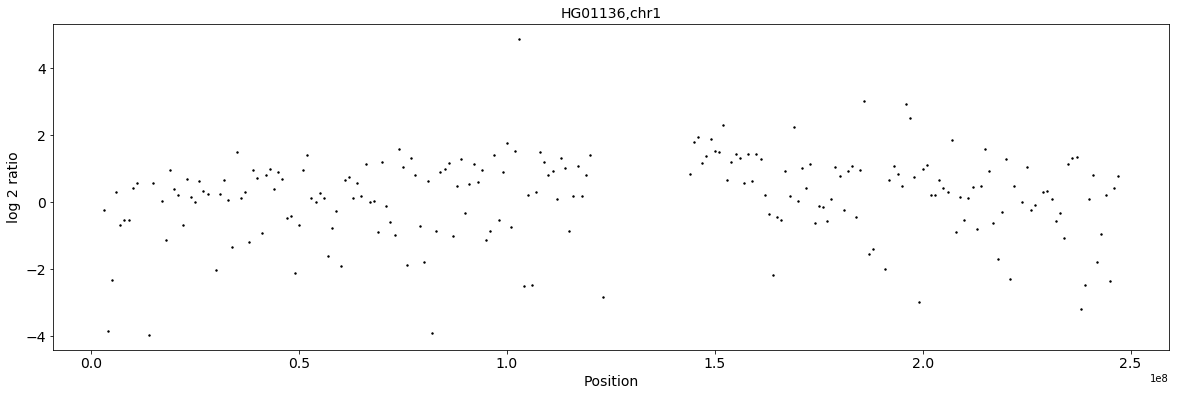

In [86]:
plt.figure(figsize=(20,6))
plt.scatter(start_pos,i_copy,s=2,c='k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position',fontsize=14)
plt.ylabel('log 2 ratio',fontsize=14)
plt.title('HG01136,chr1',fontsize=14)
